# 8 Gaussians dataset

Learn probabilistic models for 2D dataset sampled from a mixture of 8 Gaussians located in a clocklike configuration.


In [51]:
using Plots
using Random
#using Pkg; Pkg.activate("..")
using RPCircuits

## Generating the data

In [265]:
# Generates 2D dataset of N points
# sampled from Gaussian mixture model with components having variance σ^2
function generate_data(N=200, σ=0.1)
    scale = sqrt(2)/2
    unscaled_centers = [(1, 0), (-1, 0), (0, 1), (0, -1), 
            (1. / sqrt(2), 1. / sqrt(2)),
            (1. / sqrt(2), -1. / sqrt(2)), 
            (-1. / sqrt(2), 1. / sqrt(2)), 
            (-1. / sqrt(2), -1. / sqrt(2))]
    centers = [(scale * p[1], scale * p[2]) for p in unscaled_centers]
    dataset = σ*randn(N, 2)
    for i in 1:N
        idx = rand(1:length(centers))
        center = centers[idx]
        dataset[i,:] .+= center
    end
    dataset
end

generate_data (generic function with 3 methods)

Let us generate some training and test data

In [266]:
data = generate_data(200, 0.05); # generate dataset

In [267]:
testset = generate_data(1000, 0.05); # generate dataset

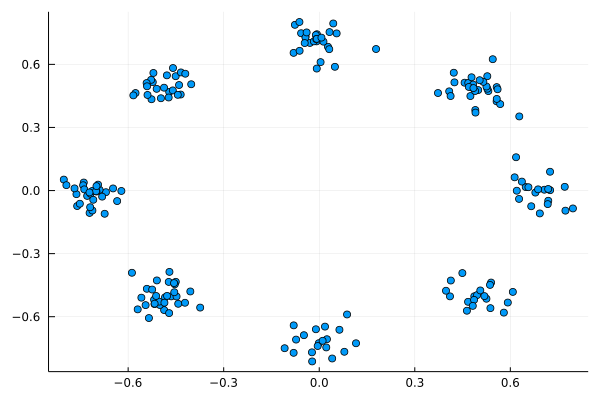

In [268]:
# Plot data
scatter(data[:,1], data[:,2]; legend = false)r = 1/(2*sqrt(2))

## Density estimation

We first learn a Gaussian Mixture Model with the same no. of components as the sampling distribution

In [343]:
σ2 = 0.01
r = sqrt(2)/2
GMM = Circuit([
        Sum(collect(2:9), ones(8)/8), # 1
        Product([10,11]), # 2
        Product([12,13]), # 3
        Product([14,15]), # 4
        Product([16,17]), # 5
        Product([18,19]), # 6
        Product([20,21]), # 7
        Product([22,23]), # 8
        Product([24,25]), # 9
        Gaussian(1, 0, σ2), # 10
        Gaussian(2, -r, σ2), # 11
        Gaussian(1, 0, σ2), # 12
        Gaussian(2, r, σ2), # 13
        Gaussian(1, r, σ2), # 14
        Gaussian(2, 0, σ2), # 15
        Gaussian(1, -r, σ2), # 16
        Gaussian(2, 0, σ2), # 17
        Gaussian(1, r/sqrt(2), σ2), # 18
        Gaussian(2, r/sqrt(2), σ2), # 19
        Gaussian(1, -r/sqrt(2), σ2), # 20
        Gaussian(2, r/sqrt(2), σ2), # 21
        Gaussian(1, r/sqrt(2), σ2), # 22
        Gaussian(2, -r/sqrt(2), σ2), # 23
        Gaussian(1, -r/sqrt(2), σ2), # 24
        Gaussian(2, -r/sqrt(2), σ2) # 25
        ]
)

Circuit with 25 nodes (1 sum, 8 products, 0 projections, 16 leaves) and 2 variables:
  1  : + 2 0.125 3 0.125 4 0.125 5 0.125 6 0.125 7 0.125 8 0.125 9 0.125
  2  : * 10 11
  3  : * 12 13
  4  : * 14 15
  5  : * 16 17
  6  : * 18 19
  7  : * 20 21
  8  : * 22 23
  9  : * 24 25
  10 : gaussian 1 0.0 0.01
  11 : gaussian 2 -0.7071067811865476 0.01
  12 : gaussian 1 0.0 0.01
  13 : gaussian 2 0.7071067811865476 0.01
  14 : gaussian 1 0.7071067811865476 0.01
  15 : gaussian 2 0.0 0.01
  16 : gaussian 1 -0.7071067811865476 0.01
  17 : gaussian 2 0.0 0.01
  18 : gaussian 1 0.5 0.01
  19 : gaussian 2 0.5 0.01
  20 : gaussian 1 -0.5 0.01
  21 : gaussian 2 0.5 0.01
  22 : gaussian 1 0.5 0.01
  23 : gaussian 2 -0.5 0.01
  24 : gaussian 1 -0.5 0.01
  25 : gaussian 2 -0.5 0.01

In [323]:
# Entropy
NLL(GMM, testset)/log(2)

-0.6198884955549783

In [305]:
# To visualize the learned density
function plot_circuit(PC; N=100, limit=1.0)
    grid = [collect(i) for i in Iterators.product(LinRange(-limit,limit,N), LinRange(-limit,limit,N))]
    density = zeros(N,N)
    for i=1:N, j=1:N
        density[i,j] = PC(grid[i,j]) #exp(plogpdf(PC, grid[i,j]))
    end
    heatmap(LinRange(-limit,limit,N),LinRange(-limit,limit,N),density)
end

plot_circuit (generic function with 1 method)

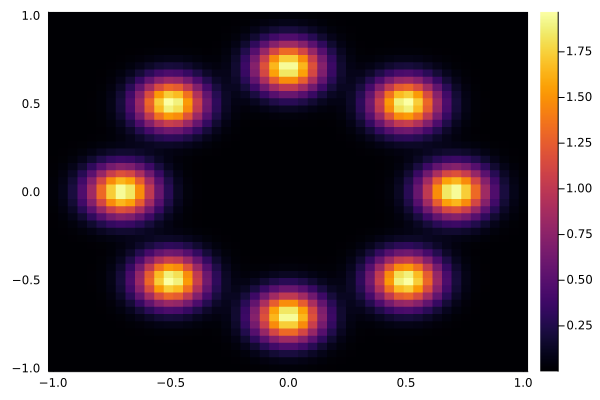

In [307]:
# Show distribution
plot_circuit(GMM; N=50, limit=1.)

In [342]:
# Runs EM to learn parameters
function learn_parameters!(PC, X, Y; steps=10, batchsize=100, verbose=true, minvar=0.0001, learning_rate=0.975, decay=true)
    learner = SEM(PC)
    indices = shuffle!(collect(1:size(X,1)))
    avgnll = 0.0
    runnll = 0.0
    η = learning_rate
    while learner.steps < steps
        sid = rand(1:(length(indices)-batchsize))
        batch = view(X, indices[sid:(sid+batchsize-1)], :)
        if decay
            η *= η
        end
        #update(learner, batch; learningrate=η)
        update(learner, batch; learningrate=η, smoothing=1e-8, learngaussians=true, minimumvariance=minvar)
        if verbose
            testnll = NLL(PC, Y)
            batchnll = NLL(PC, batch)
            # running average NLL
            avgnll *= (learner.steps-1)/learner.steps # discards initial NLL
            avgnll += batchnll/learner.steps
            runnll = (1-η)*runnll + η*batchnll
            print("It: $(learner.steps) \t avg NLL: $avgnll \t mov NLL: $runnll \t batch NLL: $batchnll \t held-out NLL: $testnll \t Learning rate: $η\n")
        end
    end
    learner    
end

learn_parameters! (generic function with 1 method)

In [348]:
# Optimize parameters using EM
#learn_parameters!(GMM, data, testset; steps=100, batchsize=10, minvar=0.001, learning_rate=0.1, decay=false);
learn_parameters!(GMM, data, testset; steps=10, batchsize=180, minvar=0.001, learning_rate=0.5, decay=false);

It: 1 	 avg NLL: -0.4110807146378697 	 mov NLL: -0.20554035731893486 	 batch NLL: -0.4110807146378697 	 held-out NLL: -0.4296739629554794 	 Learning rate: 0.5
It: 2 	 avg NLL: -0.626197807018576 	 mov NLL: -0.5234276283591086 	 batch NLL: -0.8413148993992823 	 held-out NLL: -0.758773778188824 	 Learning rate: 0.5
It: 3 	 avg NLL: -0.6991816445904722 	 mov NLL: -0.6842884740466866 	 batch NLL: -0.8451493197342644 	 held-out NLL: -0.758773778188824 	 Learning rate: 0.5
It: 4 	 avg NLL: -0.7685528333070513 	 mov NLL: -0.8304774367517376 	 batch NLL: -0.9766663994567886 	 held-out NLL: -0.8334085968584514 	 Learning rate: 0.5
It: 5 	 avg NLL: -0.8088138036427129 	 mov NLL: -0.9001675608685487 	 batch NLL: -0.9698576849853597 	 held-out NLL: -0.8334085968584514 	 Learning rate: 0.5
It: 6 	 avg NLL: -0.8447721015268324 	 mov NLL: -0.9623655759079891 	 batch NLL: -1.0245635909474295 	 held-out NLL: -0.9328632466015253 	 Learning rate: 0.5
It: 7 	 avg NLL: -0.8735363862946914 	 mov NLL: -1.004

In [349]:
# Entropy
NLL(GMM, testset)/log(2)

-1.2880606371580796

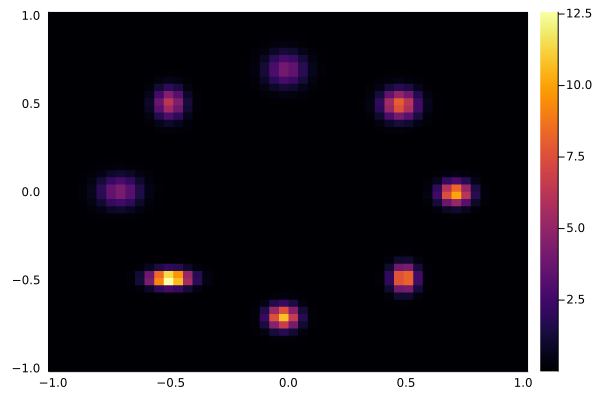

In [350]:
plot_circuit(GMM; N=50)

In [351]:
# mixture weights
GMM[1]

+ 2 0.09870605297665141 3 0.1307047185493127 4 0.09842378262373146 5 0.13298340084014412 6 0.15013853429304452 7 0.11382649612491463 8 0.1000244173454782 9 0.17519259724672295

In [352]:
# Gaussian components
leaves(GMM)

Circuit with 16 nodes (0 sums, 0 products, 0 projections, 16 leaves) and 2 variables:
  1  : gaussian 1 0.0015996823473960428 0.0035067074849220708
  2  : gaussian 2 -0.718596269244114 0.0036026569109849377
  3  : gaussian 1 -0.008991870230121105 0.0018979855604819556
  4  : gaussian 2 0.7096640488878868 0.002081864168456652
  5  : gaussian 1 0.6932258491991634 0.004156787936642453
  6  : gaussian 2 -0.011620542187138958 0.0033205148935840667
  7  : gaussian 1 -0.7114237060753257 0.0019701431745950473
  8  : gaussian 2 -0.023595164225992102 0.0019414464976139308
  9  : gaussian 1 0.4947924222732095 0.003086572815814919
  10 : gaussian 2 0.4737693024649946 0.002666094098821605
  11 : gaussian 1 -0.48976676127030955 0.002470002194371687
  12 : gaussian 2 0.49202491809885307 0.001306697847155605
  13 : gaussian 1 0.5025275015366963 0.0033891361308868843
  14 : gaussian 2 -0.5060954965360009 0.0018478725746786068
  15 : gaussian 1 -0.49219000271532753 0.0010043928451076447
  16 : gaussian 

## Probabilistic Circuits

Let's now learn a random probabilistic circuit enconding a deep Gaussian mixture model

In [353]:
C = learn_projections(data; 
                        t_proj = :max, # use :sid or :max
                        binarize = false, 
                        no_dist = true,
                        t_mix = :single, # use :single or :all
                        c = 10.0,
                        n_projs = 10,
                        min_examples = 10,
                        max_height = 5, 
                        trials = 30, 
                        dense_leaves = false
                    )

Circuit with 1263 nodes (309 sums, 318 products, 0 projections, 636 leaves) and 2 variables:
  1  : + 2 0.1 3 0.1 4 0.1 5 0.1 6 0.1 7 0.1 8 0.1 9 0.1 10 0.1 11 0.1
  2  : + 12 0.505 13 0.495
  3  : + 14 0.505 15 0.495
  4  : + 16 0.445 17 0.5549999999999999
  5  : + 18 0.445 19 0.5549999999999999
  6  : + 20 0.495 21 0.505
  7  : + 22 0.555 23 0.44499999999999995
  8  : + 24 0.555 25 0.44499999999999995
  9  : + 26 0.455 27 0.5449999999999999
  10 : + 28 0.52 29 0.48
  11 : + 30 0.53 31 0.47
  12 : + 32 0.504950495049505 33 0.49504950495049505
  13 : + 34 0.6161616161616161 35 0.38383838383838387
  14 : + 36 0.504950495049505 37 0.49504950495049505
  15 : + 38 0.6161616161616161 39 0.38383838383838387
  16 : + 40 0.42696629213483145 41 0.5730337078651686
  17 : + 42 0.45045045045045046 43 0.5495495495495495
  18 : + 44 0.42696629213483145 45 0.5730337078651686
  19 : + 46 0.4594594594594595 47 0.5405405405405406
  20 : + 48 0.37373737373737376 49 0.6262626262626263
  21 : + 50 0.504950

In [354]:
# Entropy
NLL(C, testset)/log(2)

-1.216195094621166

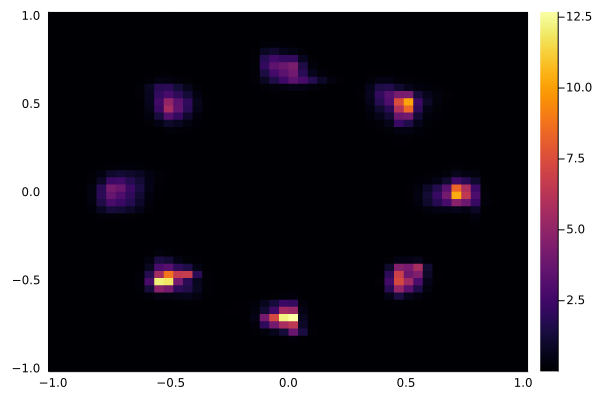

In [355]:
plot_circuit(C; N=50)

In [356]:
#learn_parameters!(C, data, testset; steps=3, batchsize=(size(data,1)-10));
learn_parameters!(C, data, testset; steps=10, batchsize=180, minvar=0.001, learning_rate=0.5, decay=false);

It: 1 	 avg NLL: -1.2746456256538623 	 mov NLL: -0.6373228128269312 	 batch NLL: -1.2746456256538623 	 held-out NLL: -0.8430022008474971 	 Learning rate: 0.5
It: 2 	 avg NLL: -1.2211342529171296 	 mov NLL: -0.902472846503664 	 batch NLL: -1.1676228801803967 	 held-out NLL: -0.8642708467224671 	 Learning rate: 0.5
It: 3 	 avg NLL: -1.1875370506326546 	 mov NLL: -1.0114077462836844 	 batch NLL: -1.1203426460637045 	 held-out NLL: -0.8642708467224671 	 Learning rate: 0.5
It: 4 	 avg NLL: -1.1887563482454893 	 mov NLL: -1.1019109936838385 	 batch NLL: -1.1924142410839929 	 held-out NLL: -0.8557480956992753 	 Learning rate: 0.5
It: 5 	 avg NLL: -1.1910423108362482 	 mov NLL: -1.1510485774415609 	 batch NLL: -1.2001861611992832 	 held-out NLL: -0.8557480956992753 	 Learning rate: 0.5
It: 6 	 avg NLL: -1.19250281817682 	 mov NLL: -1.1754269661606198 	 batch NLL: -1.1998053548796788 	 held-out NLL: -0.8432034794019074 	 Learning rate: 0.5
It: 7 	 avg NLL: -1.1985528016202585 	 mov NLL: -1.2051

In [357]:
# Entropy
NLL(C, testset)/log(2)

-1.2047503038558065

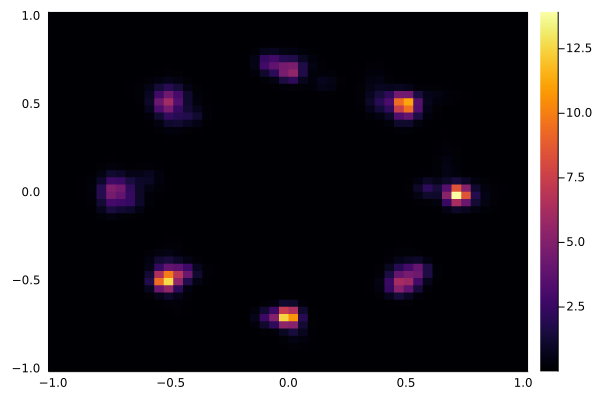

In [358]:
plot_circuit(C; N=50)

In [375]:
# As final consistency check, let's learn a univariate GMM

X = vcat(0.2*randn(30) .+ -2, 0.4*randn(70) .+ 2) # generate data from 0.3*Normal(mean=-2, variance=0.04) + 0.7*Normal(mean=2, variance=0.16)

100-element Vector{Float64}:
 -1.8479471233159683
 -2.0460581049938735
 -2.1750753320209055
 -2.3020231298274765
 -2.1711512665471906
 -1.867111023261934
 -1.6792558003313234
 -1.9130545050818364
 -1.5321272720917223
 -2.145708524942801
 -2.1974111763367565
 -1.6814841454808032
 -2.1221071215274065
  ⋮
  1.9574779065225358
  1.2876626127537216
  1.0497974642610517
  2.162735362456956
  2.2255802604658173
  2.1677984169971127
  2.0633841683735463
  1.6608352411129252
  2.230060314217026
  1.5668552637455075
  1.2723077202144784
  2.151293573045448

In [381]:
# Mixture model circuit encoding Gaussian mixture model with 2 components
G = Circuit([Sum([2,3], [0.5,0.5]), Gaussian(1, -1., 1.), Gaussian(1, 1., 1.)]) 

Circuit with 3 nodes (1 sum, 0 products, 0 projections, 2 leaves) and 1 variable:
  1 : + 2 0.5 3 0.5
  2 : gaussian 1 -1.0 1.0
  3 : gaussian 1 1.0 1.0

In [382]:
learn_parameters!(G, X, X; batchsize=29, steps=20, learning_rate=0.5, decay=false, minvar=0.001, verbose=false);

In [383]:
G

Circuit with 3 nodes (1 sum, 0 products, 0 projections, 2 leaves) and 1 variable:
  1 : + 2 0.23837554040984948 3 0.7616244595901505
  2 : gaussian 1 -1.9480508888687005 0.001
  3 : gaussian 1 1.9340039994034304 0.18904039922478916